In [1]:
import tensorflow as tf

#check tensorflow version
print(tf.__version__)
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

2.10.0
True


In [2]:
#Python libraries
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

In [3]:
#check tensorflow version
print(tf.__version__)

2.10.0


In [4]:
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

True


In [5]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [6]:
#show terminal info
terminal_info=mt5.terminal_info()
print(terminal_info)


TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=True, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=5055, maxbars=100000, codepage=0, ping_last=262123, community_balance=0.0, retransmission=4.833720030935808, company='MetaQuotes Ltd.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [7]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"
print(file_path)

C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\D0E8209F77C8CF37AD8BF550E51FF075\MQL5\Files\


In [8]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]
print("data path to save onnx model",data_path)

data path to save onnx model c:\ProgramData\anaconda3\envs\quant\lib\site-packages\


In [9]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2025-02-01 21:24:35.438063
data end date= 2025-06-01 21:24:35.438063


In [10]:
#get EURUSD rates (H1) from start_date to end_date
xauusd_rates = mt5.copy_rates_range("XAUUSD", mt5.TIMEFRAME_H1, start_date, end_date)

In [11]:
#check
print(xauusd_rates)

[(1738544400, 2804.21, 2805.79, 2784.27, 2793.06, 4564,  5, 0)
 (1738548000, 2792.49, 2796.96, 2790.35, 2792.31, 3874,  5, 0)
 (1738551600, 2792.07, 2792.21, 2778.2 , 2782.27, 5081,  5, 0) ...
 (1748638800, 3290.95, 3295.02, 3290.95, 3293.78, 3514, 17, 0)
 (1748642400, 3293.81, 3295.14, 3291.69, 3294.86, 3529, 16, 0)
 (1748646000, 3294.92, 3295.71, 3288.72, 3288.72, 1987, 16, 0)]


In [12]:
#create dataframe
df = pd.DataFrame(xauusd_rates)

In [13]:
#show dataframe head
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1738544400,2804.21,2805.79,2784.27,2793.06,4564,5,0
1,1738548000,2792.49,2796.96,2790.35,2792.31,3874,5,0
2,1738551600,2792.07,2792.21,2778.20,2782.27,5081,5,0
3,1738555200,2782.26,2782.77,2773.80,2778.10,5680,5,0
4,1738558800,2778.10,2778.26,2772.17,2774.41,4637,5,0


In [14]:
#show dataframe tail
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
1923,1748631600,3288.59,3295.66,3284.05,3293.52,4701,11,0
1924,1748635200,3293.32,3294.77,3289.79,3290.95,3897,16,0
1925,1748638800,3290.95,3295.02,3290.95,3293.78,3514,17,0
1926,1748642400,3293.81,3295.14,3291.69,3294.86,3529,16,0
1927,1748646000,3294.92,3295.71,3288.72,3288.72,1987,16,0


In [15]:
#show dataframe shape (the number of rows and columns in the data set)
df.shape

(1928, 8)

In [16]:
#prepare close prices only
data = df.filter(['close']).values

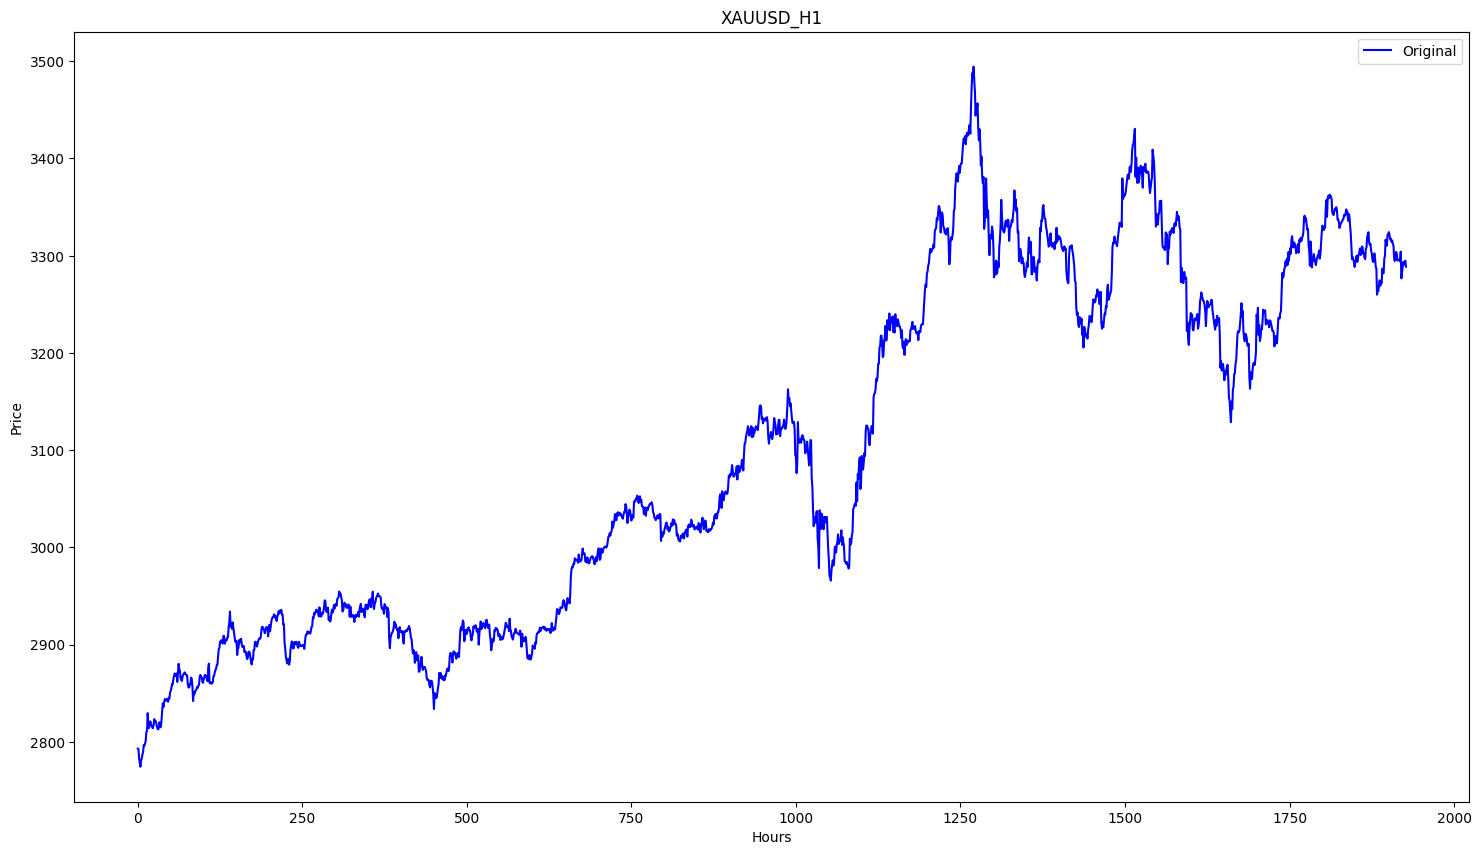

In [17]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.ylabel("Price")
plt.title("XAUUSD_H1")
plt.legend()

In [18]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [19]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1542


In [20]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

1542


In [21]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

386


In [22]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [23]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [24]:
#show shape of train data
x_train.shape

(1422, 120, 1)

In [25]:
#show shape of test data
x_test.shape

(266, 120, 1)

In [26]:
#import keras libraries for the model
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [27]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [28]:
#show model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 60, 100)           142800    
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [29]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 300 epochs
history=model.fit(x_train,y_train,epochs=300,validation_data=(x_test,y_test),batch_size=32,verbose=1)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/300
45/45 [==============================] - 5s 23ms/step - loss: 0.0153 - root_mean_squared_error: 0.1239 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 2/300
45/45 [==============================] - 1s 14ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 3/300
45/45 [==============================] - 1s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 4/300
45/45 [==============================] - 1s 14ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 5/300
45/45 [==============================] - 1s 14ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 6/300
45/45 [==============================] - 1s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 0.0013 - val_

In [30]:
#show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

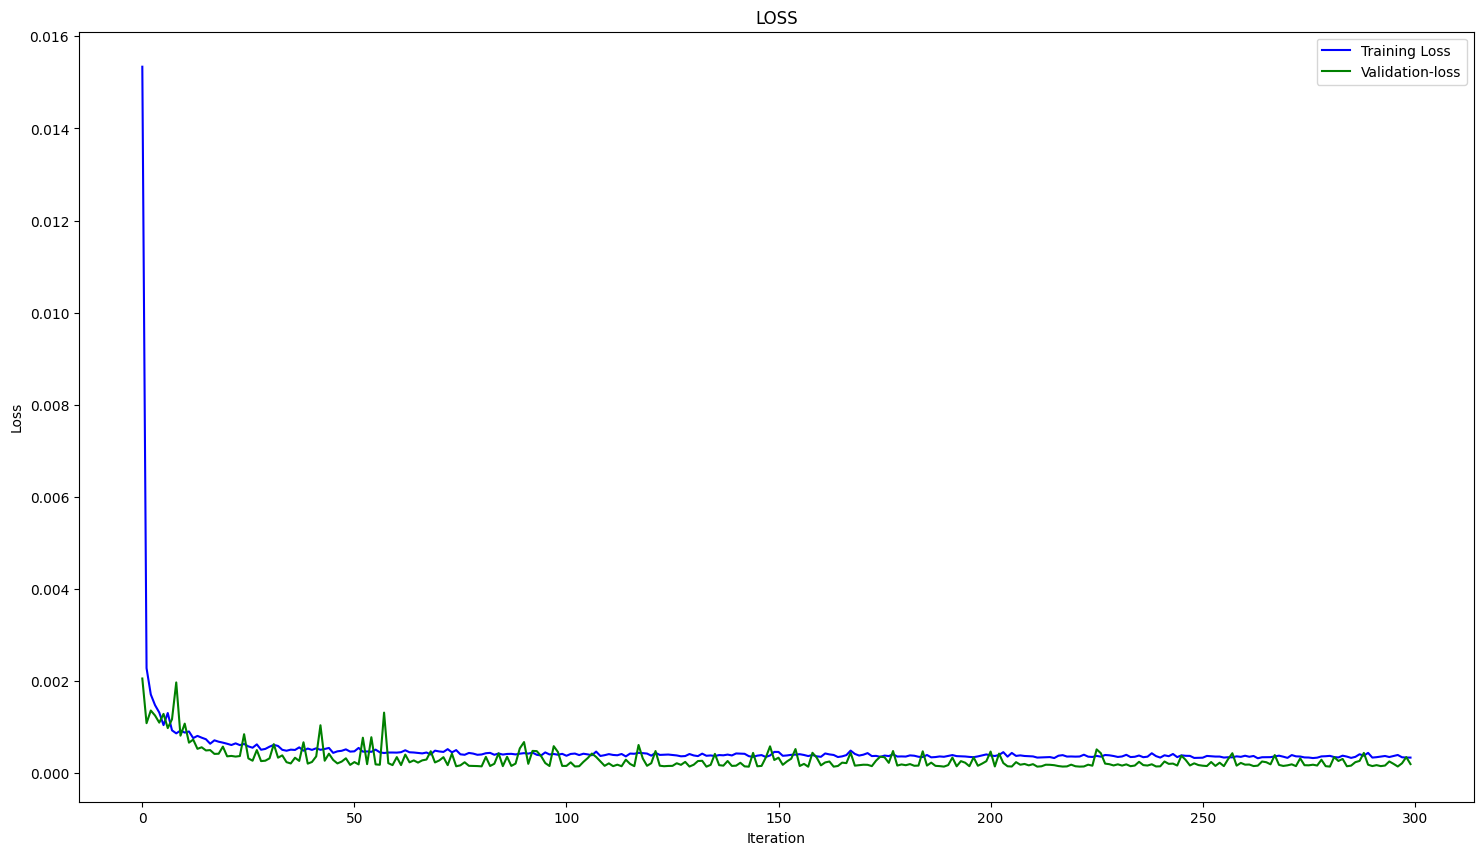

In [31]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("LOSS")
plt.legend()

In [32]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

45/45 [==============================] - 0s 7ms/step - loss: 1.6440e-04 - root_mean_squared_error: 0.0128


[0.00016439535829704255, 0.012821675278246403]

In [33]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

9/9 [==============================] - 0s 6ms/step - loss: 1.9732e-04 - root_mean_squared_error: 0.0140


[0.00019732311193365604, 0.014047174714505672]

In [34]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

45/45 [==============================] - 1s 6ms/step


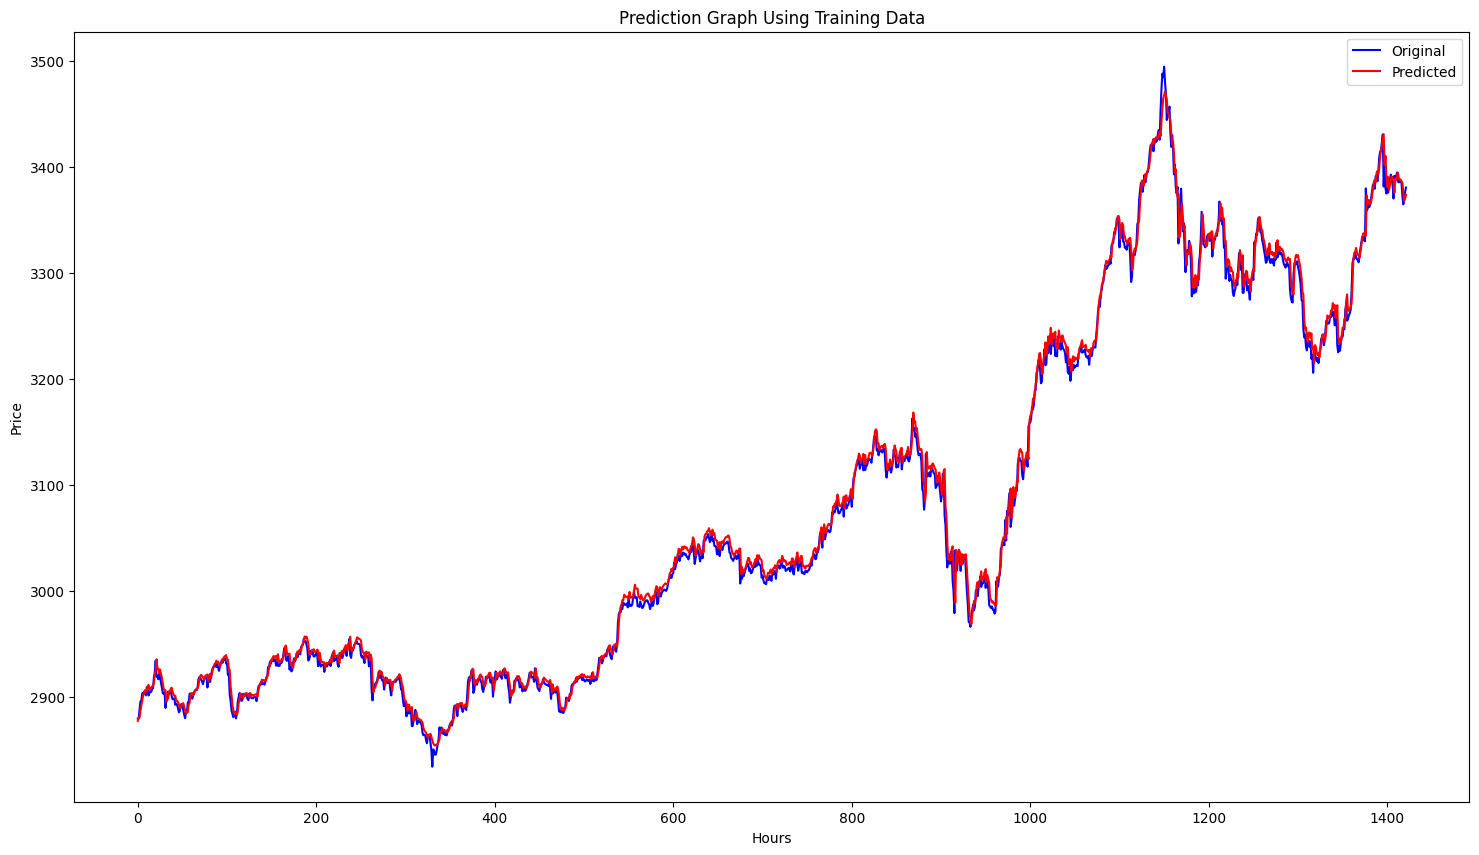

In [35]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [36]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

9/9 [==============================] - 0s 7ms/step


In [37]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 10.112697249182592
MSE          : 102.26664565362515
R2 score     : 0.958115460284086


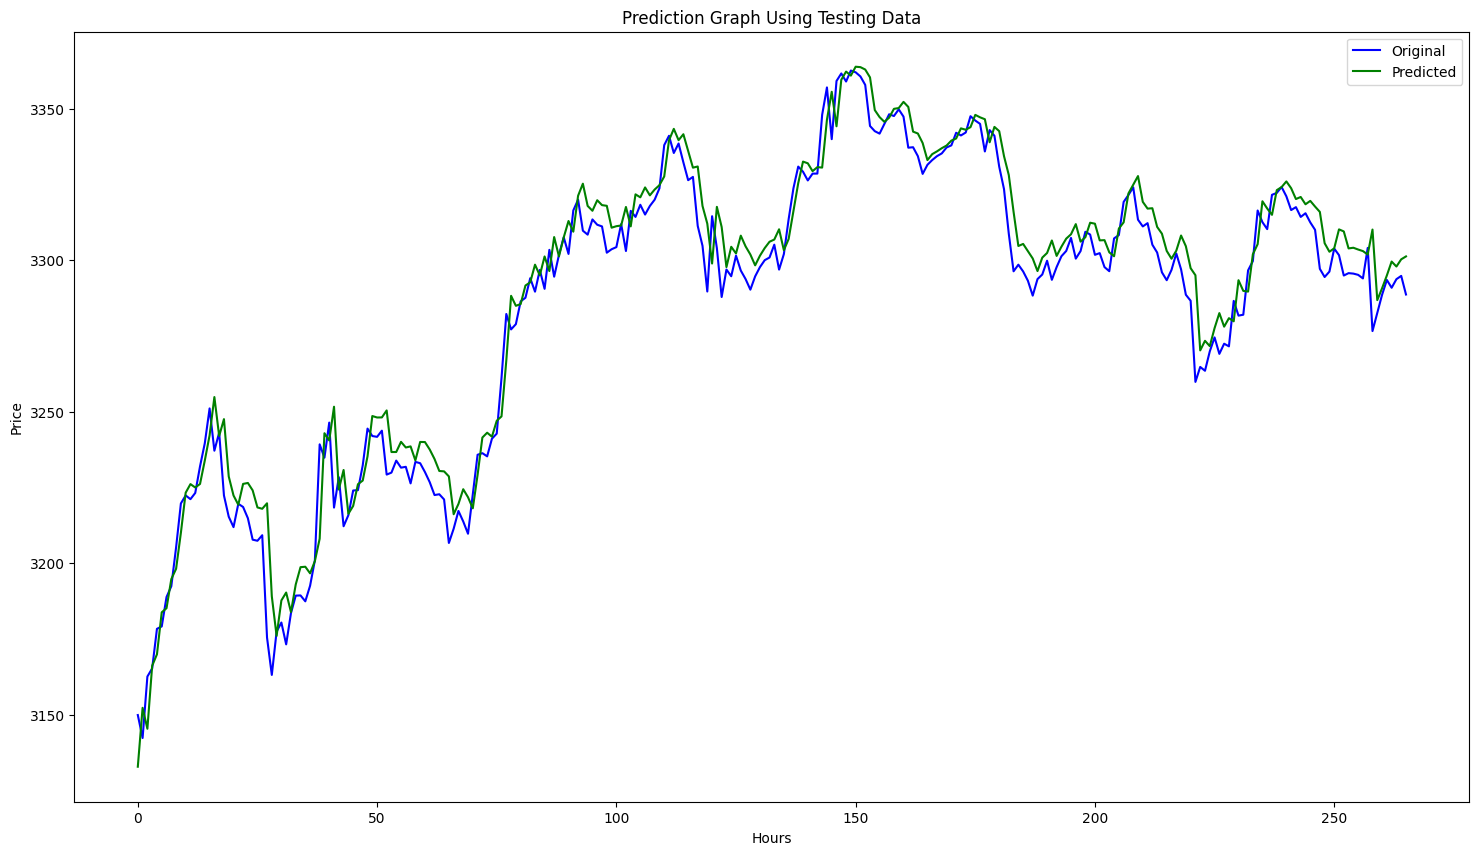

In [38]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

In [39]:
# save model to ONNX
output_path = file_path+"model.xauusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"model saved to {output_path}")

output_path = "model.xauusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)
print(f"saved model to {output_path}")

# finish
mt5.shutdown()

model saved to C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\D0E8209F77C8CF37AD8BF550E51FF075\MQL5\Files\model.xauusd.H1.120.onnx
saved model to model.xauusd.H1.120.onnx


True